In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# Load datasets
movies = pd.read_csv('/content/gdrive/My Drive/Datasets/Movielens/movies_small.csv')
ratings = pd.read_csv('/content/gdrive/My Drive/Datasets/Movielens/ratings_small.csv')


Mounted at /content/gdrive


In [3]:
# Drop the timestamp column from the ratings dataset
ratings = ratings.drop('timestamp', axis=1)

# Merge movies and ratings
df = pd.merge(ratings, movies, on='movieId')

# Create a user-item matrix
user_movie_matrix = df.pivot_table(index='userId', columns='title', values='rating')

# Fill NaN values with 0 (user hasn't rated the movie)
user_movie_matrix = user_movie_matrix.fillna(0)

In [5]:
# Feature extraction using TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(movies['genres'])

# Create a DataFrame with TF-IDF features
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Merge TF-IDF features with user-movie matrix using merge on movie title
user_movie_matrix_with_features = pd.merge(user_movie_matrix, tfidf_df, left_index=True, right_index=True, how='left')

# Train-test split after TF-IDF vectorization
train_data, test_data = train_test_split(user_movie_matrix_with_features, test_size=0.2, random_state=42)

# Build a simple neural network
model = Sequential([
    Dense(128, input_shape=(user_movie_matrix_with_features.shape[1],), activation='relu'),
    Dense(64, activation='relu'),
    Dense(user_movie_matrix_with_features.shape[1], activation='sigmoid')  # Updated this line
])

model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(train_data.values, train_data.values, epochs=50, batch_size=32, validation_data=(test_data.values, test_data.values))

# Make predictions on the test set
predictions = model.predict(test_data.values)


Epoch 1/50
16/16 [==============================] - 3s 34ms/step - loss: 0.3224 - val_loss: 0.2802
Epoch 2/50
16/16 [==============================] - 0s 13ms/step - loss: 0.1971 - val_loss: 0.2709
Epoch 3/50
16/16 [==============================] - 0s 11ms/step - loss: 0.1917 - val_loss: 0.2702
Epoch 4/50
16/16 [==============================] - 0s 16ms/step - loss: 0.1895 - val_loss: 0.2679
Epoch 5/50
16/16 [==============================] - 0s 15ms/step - loss: 0.1868 - val_loss: 0.2650
Epoch 6/50
16/16 [==============================] - 0s 13ms/step - loss: 0.1844 - val_loss: 0.2638
Epoch 7/50
16/16 [==============================] - 0s 9ms/step - loss: 0.1829 - val_loss: 0.2625
Epoch 8/50
16/16 [==============================] - 0s 14ms/step - loss: 0.1817 - val_loss: 0.2617
Epoch 9/50
16/16 [==============================] - 0s 11ms/step - loss: 0.1808 - val_loss: 0.2611
Epoch 10/50
16/16 [==============================] - 0s 12ms/step - loss: 0.1800 - val_loss: 0.2600
Epoch 11/5

In [6]:
# Evaluate the model (e.g., using mean squared error)
mse = tf.keras.losses.mean_squared_error(test_data.values, predictions)
print(f'Mean Squared Error: {mse.numpy()}')

Mean Squared Error: [0.22982532 0.4598781  0.04741709 1.6476953  0.17487401 0.49229455
 0.8895402  0.11321513 0.05619894 0.44434085 0.35854948 0.04654777
 0.04992832 0.04408041 0.04676283 0.05031675 0.05127624 0.5328526
 0.08044583 0.05807004 0.04501431 0.03492089 0.07972021 0.99072087
 0.27441013 0.07118853 0.26281005 0.05894015 0.04826054 0.0732693
 1.1318542  0.115824   0.0577297  0.06086419 0.48712966 0.29726747
 0.09126183 0.03763636 0.16703531 0.06891654 0.06758293 0.08290974
 0.49715135 0.4006674  0.04503656 0.24419062 0.04736793 0.04145075
 0.04054576 0.06068391 0.0163026  0.06163214 0.04709418 0.1271582
 0.0323504  0.820313   1.4111822  0.03161431 0.05972902 0.25020793
 0.26692313 0.0485677  0.24606237 0.0220267  0.4668521  0.16276892
 0.06536082 0.06586805 0.04829893 0.17725411 0.03750169 0.05426787
 0.61986846 0.62521815 0.2603282  0.34073287 0.10648744 0.1012395
 0.2448006  0.36479467 0.1429089  0.0475627  0.27150902 0.15539563
 0.29768455 0.09532838 0.25001258 0.1944628  0

In [9]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Additional Metrics
mae = mean_absolute_error(test_data.values, predictions)
print(f'Mean Absolute Error: {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(test_data.values, predictions))
print(f'Root Mean Squared Error: {rmse}')

Mean Absolute Error: 0.08918235746367208
Root Mean Squared Error: 0.4987504686994186


In [10]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity

# Cosine Similarity Matrix (Compute only for movie columns)
cosine_sim_movies = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim_movies, index=movies['title'], columns=movies['title'])

# Recommender Function
def recommend_movies(movie_title, user_movie_matrix, cosine_sim_matrix, n=5):
    # Check if the movie title is present in the cosine_sim_matrix
    if movie_title not in cosine_sim_matrix.index:
        print(f"Movie '{movie_title}' not found.")
        return []

    # Get the cosine similarity scores for the movie
    sim_scores = cosine_sim_matrix.loc[movie_title]

    # Sort the movies based on the similarity scores
    sim_scores = sim_scores.sort_values(ascending=False)

    # Get the top N similar movies
    top_movies = sim_scores[1:n+1].index

    return top_movies

# Example of using the recommender function
movie_to_recommend = 'Toy Story (1995)'
recommended_movies = recommend_movies(movie_to_recommend, movies, cosine_sim_df, n=10)

if not recommended_movies.empty:
    print(f"Recommended movies for '{movie_to_recommend}':")
    for i, movie in enumerate(recommended_movies, start=1):
        print(f"{i}. {movie}")
    # print(recommended_movies)
else:
    print(f"No recommendations found for '{movie_to_recommend}'.")


Recommended movies for 'Toy Story (1995)':
1. Toy Story 2 (1999)
2. Tale of Despereaux, The (2008)
3. Asterix and the Vikings (Astérix et les Vikings) (2006)
4. Shrek the Third (2007)
5. Turbo (2013)
6. Monsters, Inc. (2001)
7. The Good Dinosaur (2015)
8. Antz (1998)
9. Emperor's New Groove, The (2000)
10. Moana (2016)


In [11]:
print(cosine_sim_movies)

[[1.         0.81357774 0.15276924 ... 0.         0.4210373  0.26758648]
 [0.81357774 1.         0.         ... 0.         0.         0.        ]
 [0.15276924 0.         1.         ... 0.         0.         0.57091541]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.4210373  0.         0.         ... 0.         1.         0.        ]
 [0.26758648 0.         0.57091541 ... 0.         0.         1.        ]]


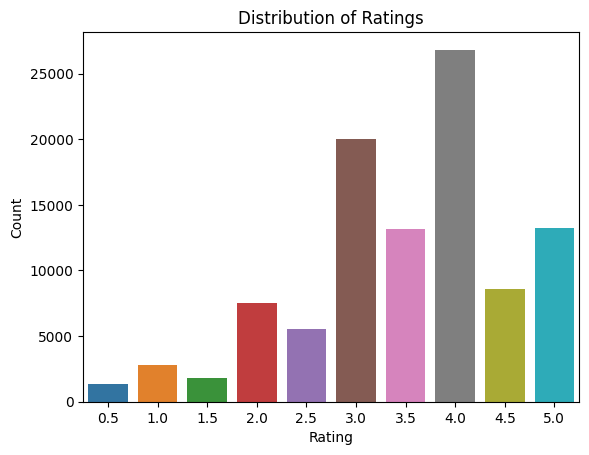

In [15]:
#count plot to visualize the distribution of ratings.
sns.countplot(x='rating', data=ratings)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


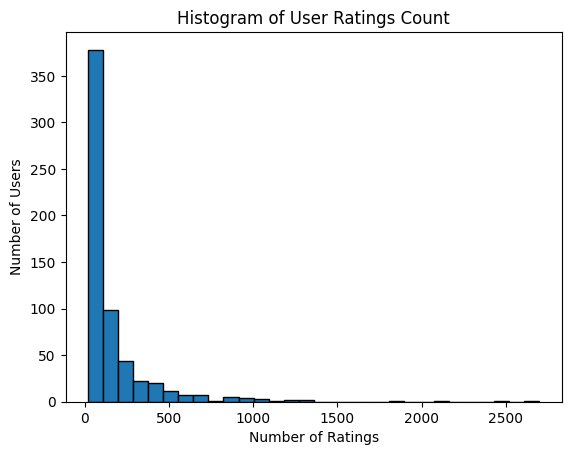

In [19]:
#Histograms are useful for visualizing the distribution of a single variable.
user_ratings_count = df.groupby('userId')['rating'].count()
plt.hist(user_ratings_count, bins=30, edgecolor='black')
plt.title('Histogram of User Ratings Count')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.show()


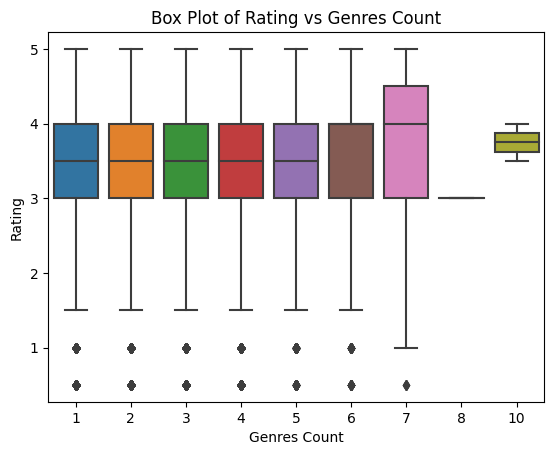

In [21]:
#Box plots are useful for visualizing the distribution of a variable and identifying outliers
# Create a new column 'genres_count' representing the number of genres for each movie
df['genres_count'] = df['genres'].apply(lambda x: len(x.split('|')))

sns.boxplot(x='genres_count', y='rating', data=df)
plt.title('Box Plot of Rating vs Genres Count')
plt.xlabel('Genres Count')
plt.ylabel('Rating')
plt.show()

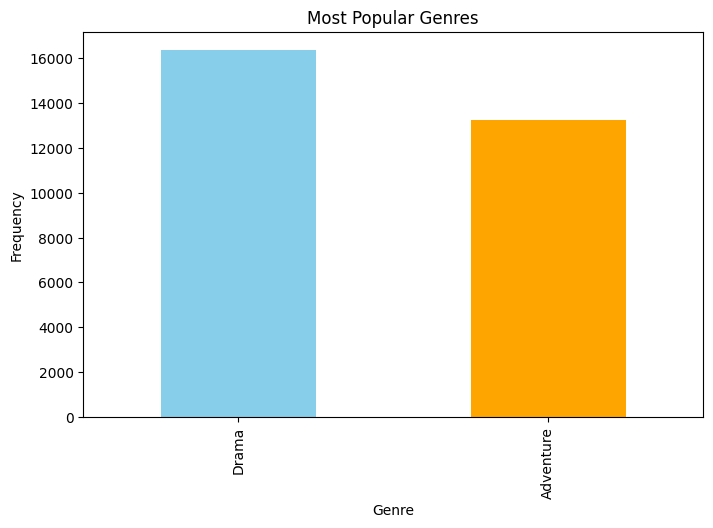

Most Popular Genre: Drama
Second Most Popular Genre: Adventure


In [24]:
# Assuming 'genres' is a string containing genres separated by '|'
# Create a new column 'genres_count' representing the number of genres for each movie
df['genres_count'] = df['genres'].apply(lambda x: len(x.split('|')))

# Identify the two most popular genres
genre_counts = pd.Series(','.join(df['genres']).split('|')).value_counts()

# Select the top two genres
top_genres = genre_counts.head(2)

# Bar Graph: Most Popular Genres
plt.figure(figsize=(8, 5))
top_genres.plot(kind='bar', color=['skyblue', 'orange'])
plt.title('Most Popular Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.show()

# Print the two most popular genres and their frequencies
print("Most Popular Genre:", top_genres.idxmax())
print("Second Most Popular Genre:", top_genres.idxmin())
